In [44]:
import numpy as np
import scipy

### Training my own model using CUDA programming

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Download the training, validation and test datasets:
https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data

#### Let's first take a look at a training image to see its dimensions

In [46]:
image1 = Image.open('Training_Set/Training/1.png')

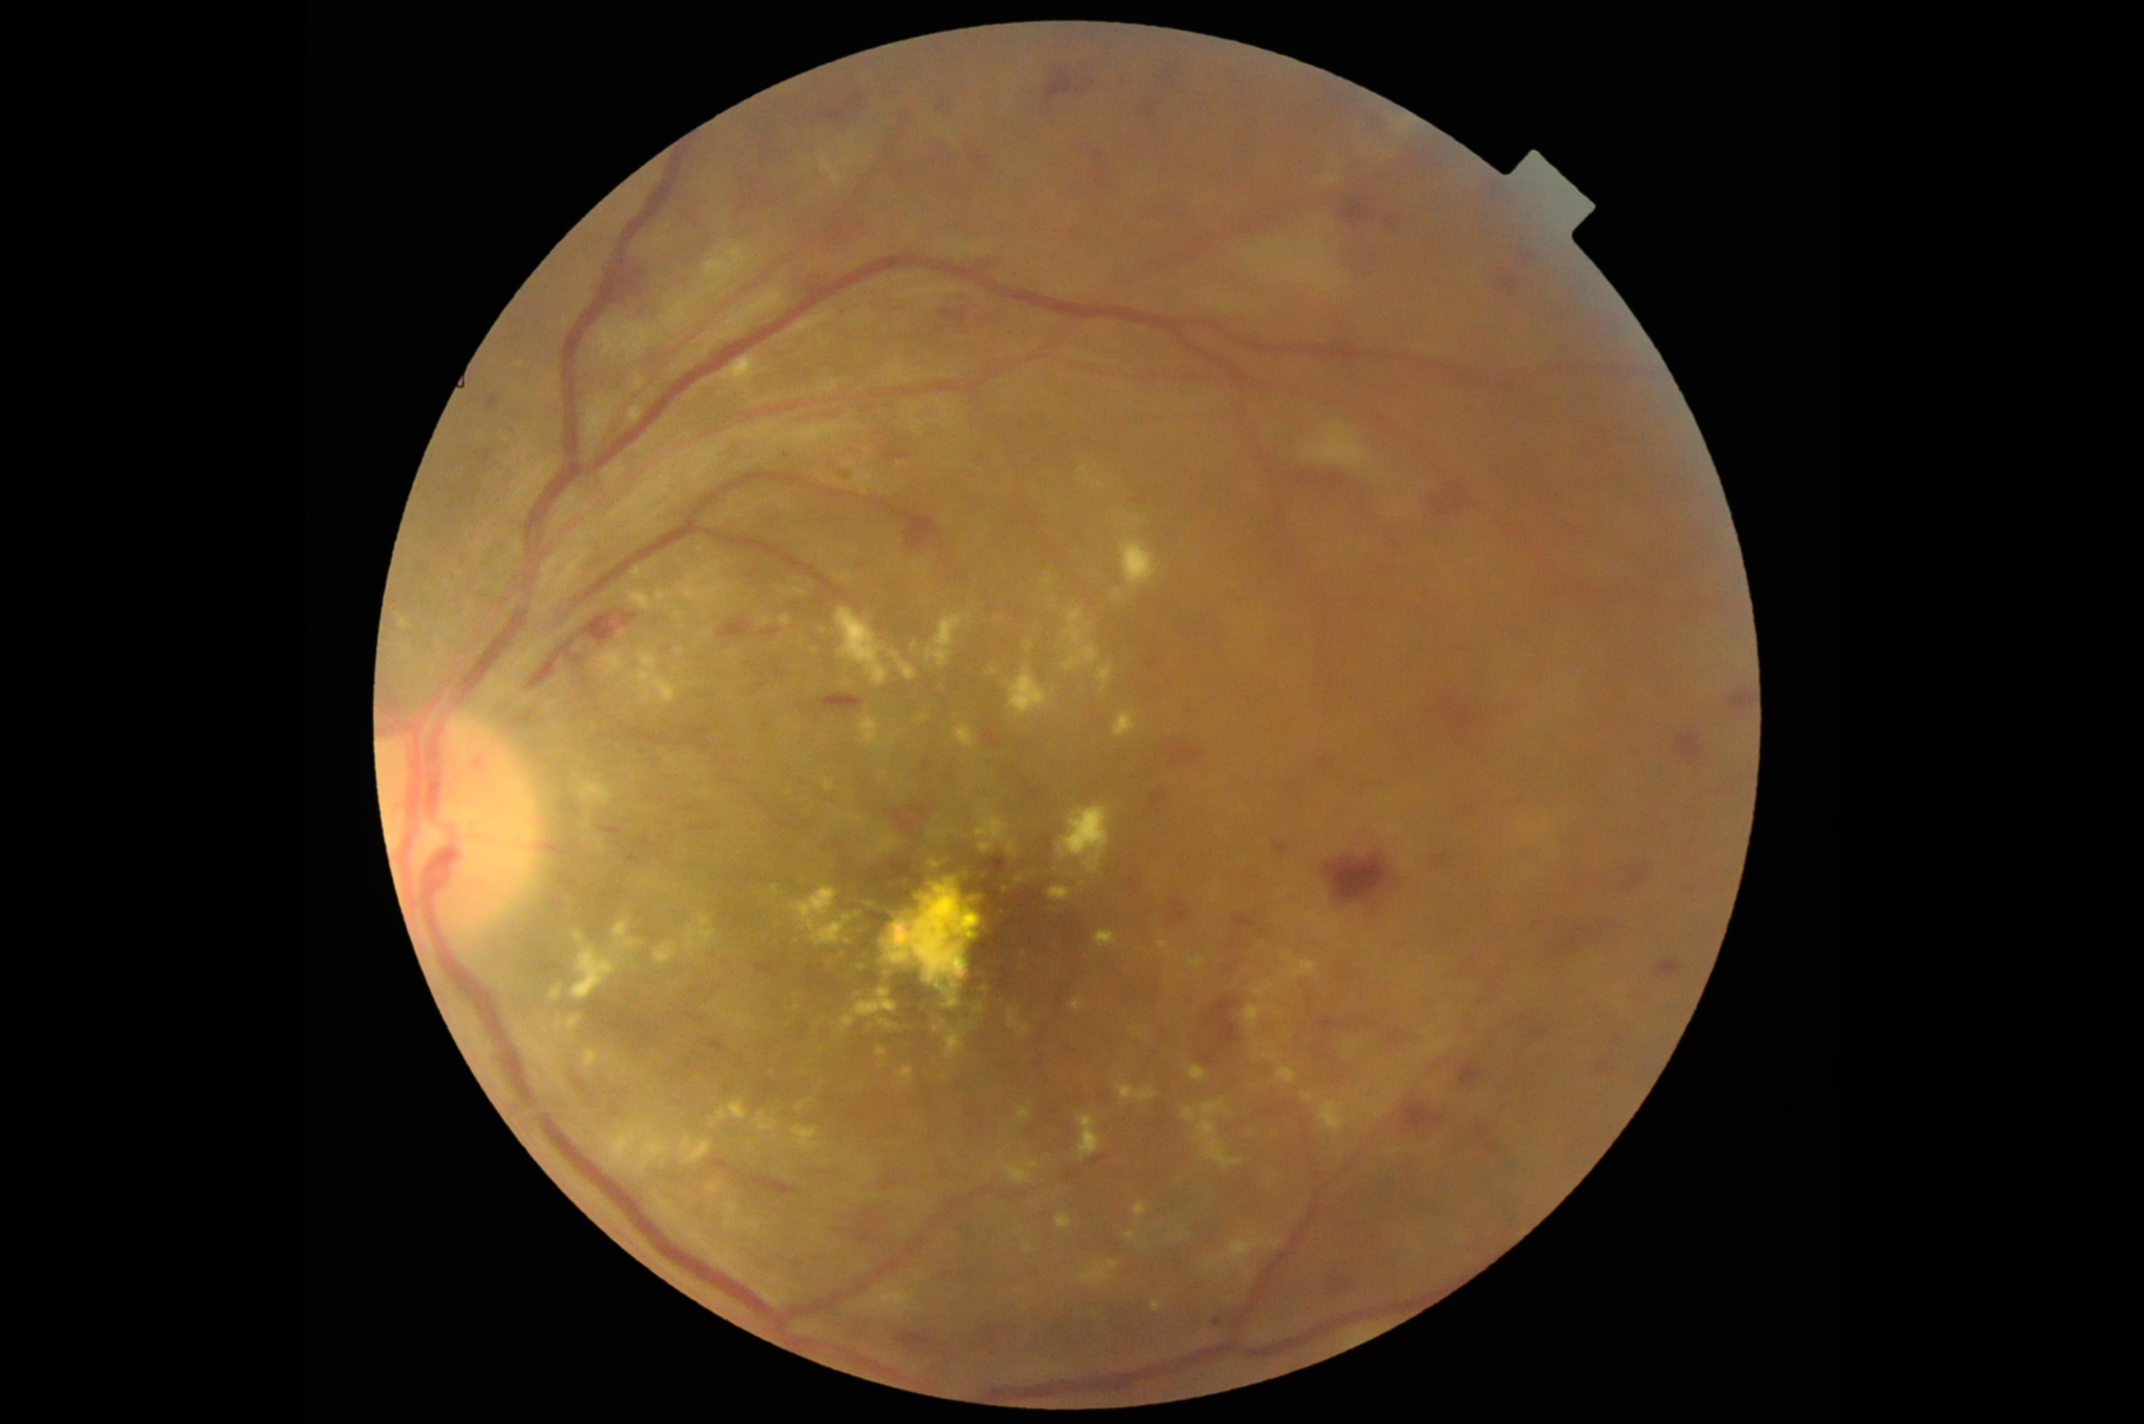

In [47]:
image1

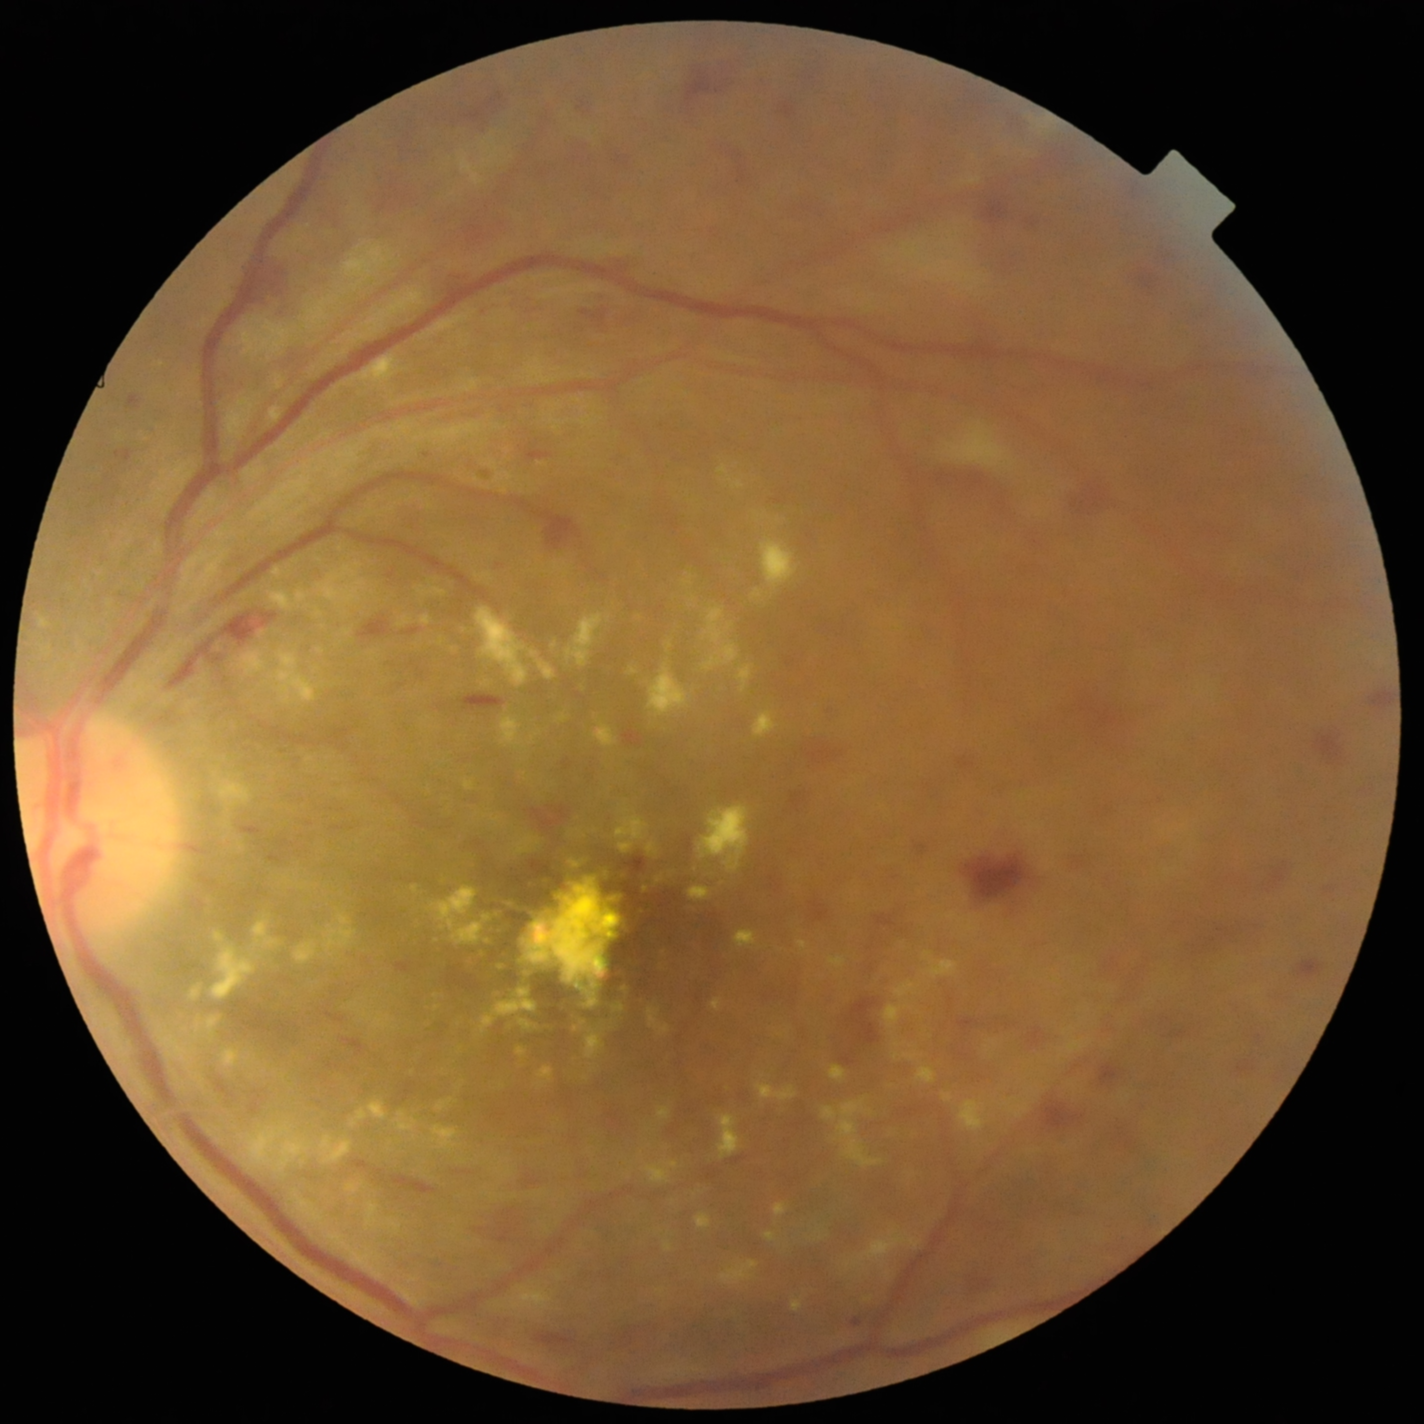

In [48]:
# looks like I can crop the image to a square by the smaller dimension
img_size = min(image1.size)
crop_margin = np.abs(image1.size[0] - image1.size[1]) // 2
cropped_img = image1.crop([crop_margin, 0, img_size+crop_margin, img_size])
cropped_img

In [49]:
print('cropped image size: {} x {}'.format(img_size, img_size))

cropped image size: 1424 x 1424


In [50]:
# Define the dataset class for the retinal images
class RetinalDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        
        img_filename = str(self.labels_df.iloc[idx, 0]) + '.png'
        img_name = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_name).convert('RGB')
        # now crop the images to a square, since I defined the transformation to be
        # square images. The crop_margin, img_size are global variables.
        image = image.crop([crop_margin, 0, img_size+crop_margin, img_size])

        # the csv file in this dataset has many different disease labels
        # for this example notebook, I will only train for one label of my choice 
        # hard coding it to a number for now
        
        label_name = self.labels_df.columns.tolist()[2]
        label = self.labels_df.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, label

In [51]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 224 is a standard for ResNet etc, trained on ImageNet
    transforms.ToTensor()
    # here are the normalization values chatgpt suggested, derived from a common dataset used to pre-train
    # models. But the retinal data set seems to be already pre-processed, I'll try no normalization first.
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [52]:
# Load training and validation dataset
train_csv_file = 'Training_Set/RFMiD_Training_Labels.csv'  
train_image_dir = 'Training_Set/Training'
train_dataset = RetinalDataset(csv_file=train_csv_file, image_dir=train_image_dir, 
                                  transform=transform)

val_csv_file = 'Evaluation_Set/RFMiD_Validation_Labels.csv'  
val_image_dir = 'Evaluation_Set/Validation'
val_dataset = RetinalDataset(csv_file=val_csv_file, image_dir=val_image_dir, 
                                  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [53]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [54]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, loss function, and optimizer
model = SimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
# Training and validation loops
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print('Epoch {}/{}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, 
                                                                               epoch_loss, val_loss))

Epoch 1/10, Training Loss: 0.8345, Validation Loss: 0.4587
Epoch 2/10, Training Loss: 0.4292, Validation Loss: 0.4902
Epoch 3/10, Training Loss: 0.4329, Validation Loss: 0.4381
Epoch 4/10, Training Loss: 0.4240, Validation Loss: 0.4301
Epoch 5/10, Training Loss: 0.4084, Validation Loss: 0.4311
Epoch 6/10, Training Loss: 0.4147, Validation Loss: 0.4210
Epoch 7/10, Training Loss: 0.3998, Validation Loss: 0.4120
Epoch 8/10, Training Loss: 0.3894, Validation Loss: 0.4122
Epoch 9/10, Training Loss: 0.3926, Validation Loss: 0.4205
Epoch 10/10, Training Loss: 0.3850, Validation Loss: 0.4064


### Plotting some metrics

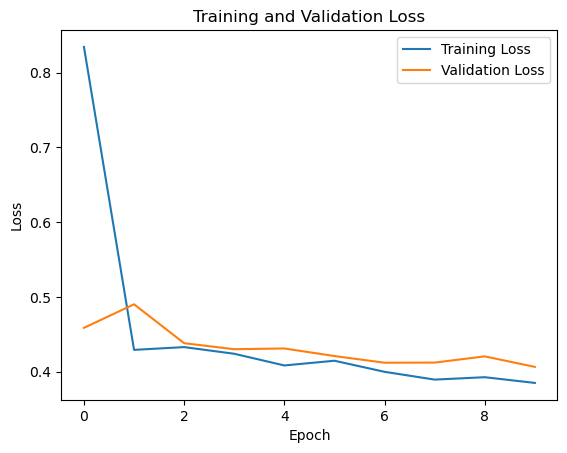

Accuracy of the model on validation images: 83.12%


In [56]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Testing the model on validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on validation images: {:.2f}%'.format(100 * correct / total))

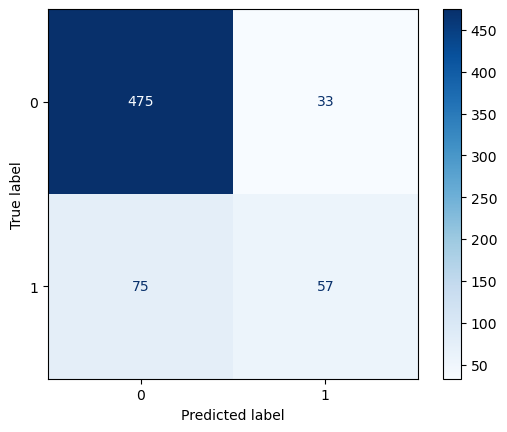

In [57]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Test the model

In [58]:
# Define a test dataset class (similar to the training and validation dataset class)
test_dataset = RetinalDataset(csv_file='Test_Set/RFMiD_Testing_Labels.csv', 
                              image_dir='Test_Set/Test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate model on test set and calculate accuracy
model.eval()
correct = 0
total = 0

# I want to plot a few correct and incorrect examples
correct_images = []
incorrect_images = []
correct_labels = []
incorrect_labels = []
correct_preds = []
incorrect_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Store correct predictions
        correct_mask = preds == labels
        if correct_images and len(correct_images) >= 3 and len(incorrect_images) >= 3:
            pass
        else:
            for i in range(len(images)):
                if correct_mask[i] and labels[i]==1:
                    if len(correct_images) < 3:
                        correct_images.append(images[i].cpu())
                        correct_labels.append(labels[i].cpu())
                        correct_preds.append(preds[i].cpu())
                else:
                    if len(incorrect_images) < 3:
                        incorrect_images.append(images[i].cpu())
                        incorrect_labels.append(labels[i].cpu())
                        incorrect_preds.append(preds[i].cpu())

In [59]:
accuracy = correct / total
print('Test Accuracy: {:.2f}%'.format(accuracy * 100))

Test Accuracy: 81.09%


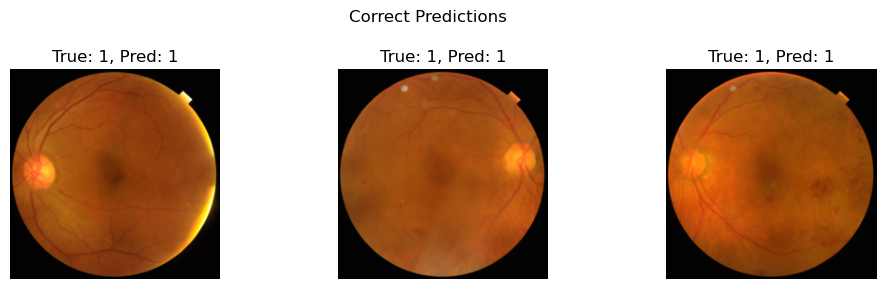

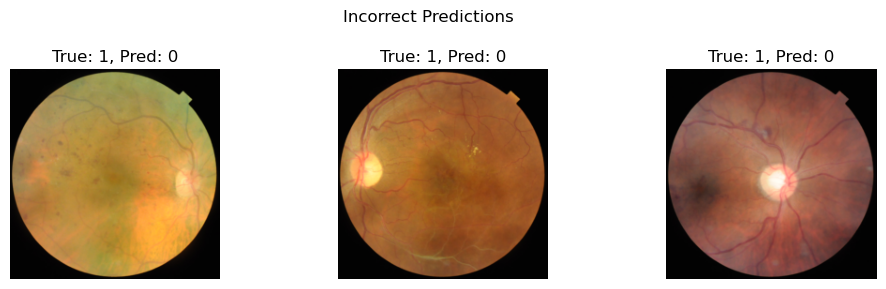

In [60]:
# Plot correct predictions
plt.figure(figsize=(12, 6))
for i in range(len(correct_images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(transforms.ToPILImage()(correct_images[i]))
    plt.title("True: {}, Pred: {}".format(correct_labels[i], correct_preds[i]))
    plt.axis('off')
plt.suptitle("Correct Predictions")
plt.show()

# Plot incorrect predictions
plt.figure(figsize=(12, 6))
for i in range(len(incorrect_images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(transforms.ToPILImage()(incorrect_images[i]))
    plt.title("True: {}, Pred: {}".format(incorrect_labels[i], incorrect_preds[i]))
    plt.axis('off')
plt.suptitle("Incorrect Predictions")
plt.show()

### Pre-trained ResNet-50 model
Not actually sure what exactly this model is and how it's trained, the arxiv link is here if I have time to read it: https://arxiv.org/abs/1512.03385

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os

In [ ]:
# I will use the same retinal dataset class and transformations as previously
# the following code I copied from an example, will need to download a pre-trained model
# and then download a test dataset to try it out.

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 5) 
model.load_state_dict(torch.load('I need to download a pre-trained model from somewhere'))
model.eval()

# Prepare dataset and dataloader
dataset = RetinalDataset('', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Prediction function
def predict_image(image):
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Example: Predict on a new image
img_path = 'path/to/test_image.jpg'  # Replace with path to a new retinal image
image = Image.open(img_path).convert('RGB')
image = transform(image)
class_idx = predict_image(image)
print('Predicted class index: {}'.format(class_idx))